## List 3

In [94]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import statsmodels as sm

### Task 1
Generate:
- a random walk with normally distributed increments: $y_t = y_{t-1} + \varepsilon_t \sim \mathcal{N}(\mu=0, \sigma=2)$
- random walk with a drift: $y_t = c + y_{t-1} + \varepsilon_t \sim \mathcal{N}(\mu=0, \sigma=2)$
- trend-stationary time series: $y_t = at + \varepsilon_t \sim \mathcal{N}(\mu=0, \sigma=2)$

In [95]:
T = 100
c = 1
a = 1
mu = 0
sigma = 2

random_walk = np.full(T, 0.0)
random_walk_drift = np.full(T, 0.0)
trend_stationary = np.full(T, 0.0)

for t in range(1, T):
    random_walk[t] = random_walk[t-1] + (np.random.randn()*sigma + mu)
    random_walk_drift[t] = c + random_walk_drift[t-1] + (np.random.randn()*sigma + mu)
    trend_stationary[t] = a*t + (np.random.randn()*sigma + mu)

### Task 2
Check visually the stationarity of original and differenced samples from the previous task.

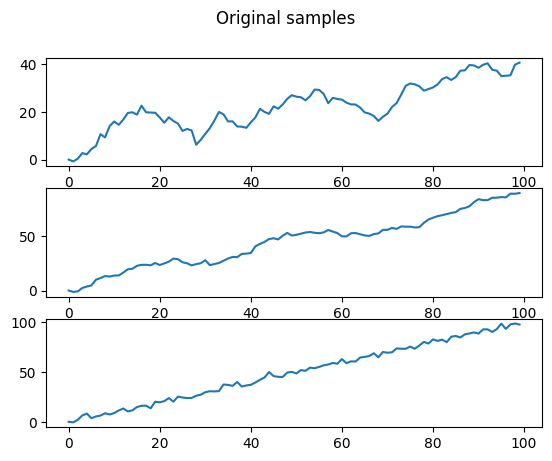

In [96]:
fig, axs = plt.subplots(3)
fig.suptitle('Original samples')
axs[0].plot(random_walk)
axs[1].plot(random_walk_drift)
axs[2].plot(trend_stationary)

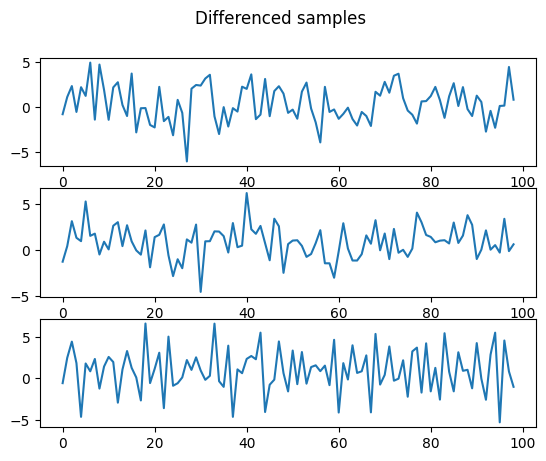

In [97]:
fig, axs = plt.subplots(3)
fig.suptitle('Differenced samples')
axs[0].plot(np.diff(random_walk))
axs[1].plot(np.diff(random_walk_drift))
axs[2].plot(np.diff(trend_stationary))

### Task 3
Plot the DJI time series (from the dji.csv file), assess the data stationarity visually, with the autocorrelation plot and with the ADF test.

In [98]:
df = pl.read_csv("data/dji.csv", separator=',', has_header=True)
df

Date,Close
str,f64
"""1896-05-27""",29.39
"""1896-05-28""",29.11
"""1896-05-29""",29.43
"""1896-06-01""",29.4
"""1896-06-02""",29.0
…,…
"""2022-10-12""",29210.85
"""2022-10-13""",30038.72
"""2022-10-14""",29634.83


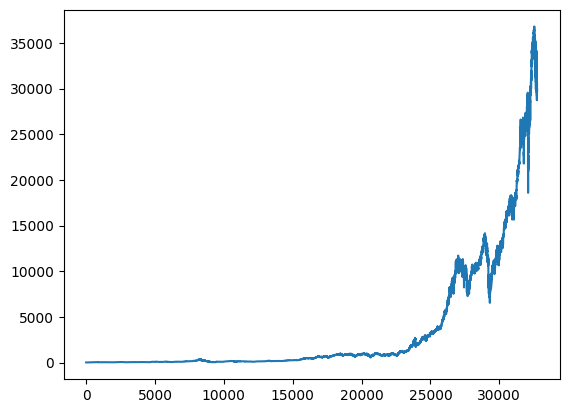

In [99]:
y = df.select(pl.col('Close')).to_numpy().ravel()
plt.plot(y)

Automatic tool for plotting autocorrelation:

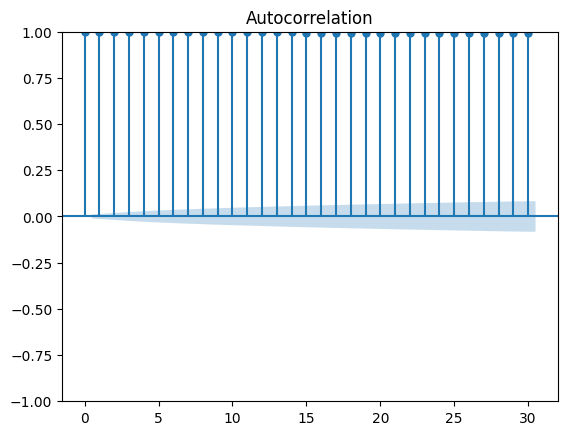

In [100]:
sm.graphics.tsaplots.plot_acf(y, lags=30);

Our own function for computing autocorrelation:

Augmented Dickey-Fuller test from statsmodels:

In [101]:
sm.api.tsa.stattools.adfuller(y)

(np.float64(3.9088464325393426),
 1.0,
 50,
 32691,
 {'1%': np.float64(-3.4305500493575902),
  '5%': np.float64(-2.8616284166759427),
  '10%': np.float64(-2.5668170614519528)},
 np.float64(381788.1638121413))

### Task 4
Check the stationarity of the differenced data (with the autocorrelation plot and with the ADF test).

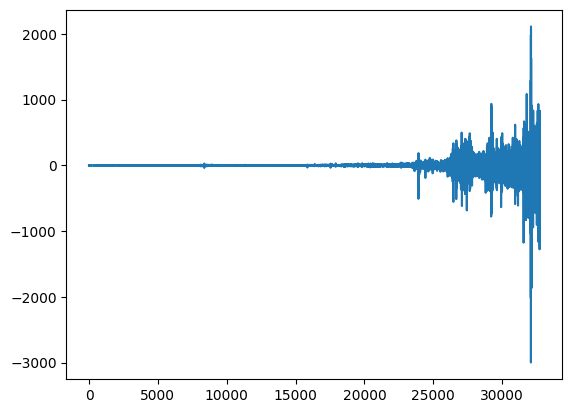

In [102]:
dy = np.diff(y)
plt.plot(dy)

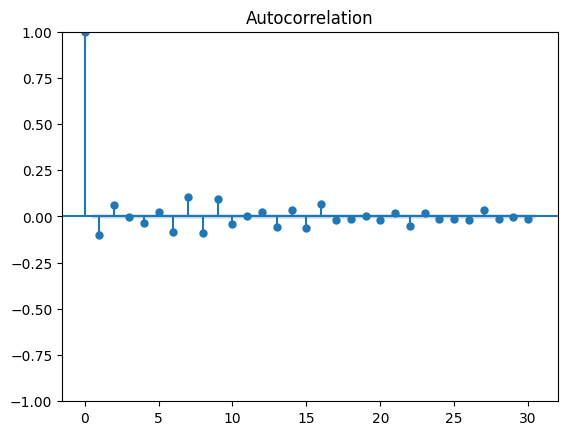

In [103]:
sm.graphics.tsaplots.plot_acf(dy, lags=30);

In [ ]:
sm.api.tsa.stattools.adfuller(dy)

### Task 5

Check the stationarity of the logarithmic returns of DJI time series (with the autocorrelation plot and with the ADF test).

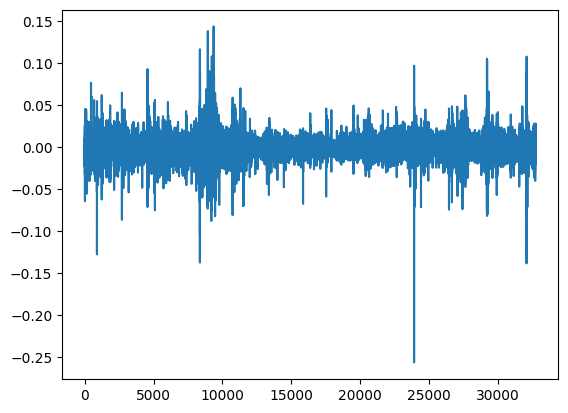

In [ ]:
logr = np.log(y[1:]/y[:-1])
plt.plot(logr)

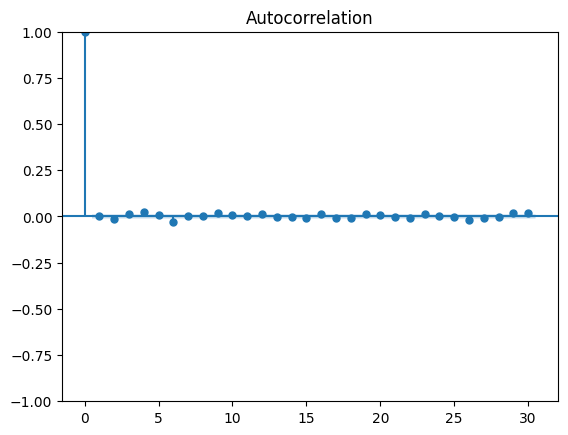

In [ ]:
sm.graphics.tsaplots.plot_acf(logr, lags=30);

In [ ]:
sm.api.tsa.stattools.adfuller(logr)

(np.float64(-25.47117807017673),
 0.0,
 47,
 32693,
 {'1%': np.float64(-3.4305500371185746),
  '5%': np.float64(-2.8616284112667945),
  '10%': np.float64(-2.5668170585727994)},
 np.float64(-200817.4616166193))

### Task 6
Write a function which will return the order of integration of
input data (based on the AFD test).

In [ ]:
def integration_order(y, max_diff, significance):
    order_diff = -1
    p_value = float('inf')
    while p_value > significance and order_diff < max_diff:
        res = sm.tsa.stattools.adfuller(y)
        p_value = res[1]
        order_diff += 1
        y = np.diff(y)
    return order_diff, p_value

print("Original: ", integration_order(y, 10, 0.05))
print("Differenced: ", integration_order(dy, 10, 0.05))
print("Log returns: ", integration_order(logr, 10, 0.05))

Original:  (1, 0.0)
Differenced:  (0, 0.0)
Log returns:  (0, 0.0)


### Autocorrelation
Our own function for computing autocorrelation:


In [ ]:
def autocorr(y, max_lag):
    y_mean = np.mean(y) # y^bar
    denominator = np.sum(np.square(y-y_mean))
    T = len(y)
    result = np.full(max_lag+1, np.nan)
    for k in range(0, max_lag+1): # from 0 to max_lag included
        nominator = 0
        if k >= T:
            raise ValueError(f"Timeseries too short for lag {k}")
        for t in range(k, T):
            nominator += (y[t]-y_mean)*(y[t-k]-y_mean)
        result[k] = nominator/denominator
    return result

# compare the results of our function with statsmodels acf:
print(autocorr(y, 10))
print(sm.api.tsa.stattools.acf(y, nlags=10))